In [1]:
from copy import deepcopy
from pathlib import Path
import pickle
import json
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("gene_name_map.json") as f:
    GENE_NAME_MAP = json.load(f)

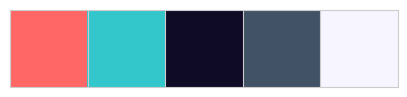

In [3]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [4]:
def _filt_self_from_de(pert_data, is_norman: bool):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
    rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

    updated_rank_genes_groups_cov_all = {}

    for k, v in rank_genes_groups_cov_all.items():
        condition = k.split("_")[1]
        condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

        if is_norman:
            condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
            updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
        else:
            if "+" in condition_gene_name:
                condition_gene_name = condition_gene_name.split("+")
                assert len(condition_gene_name) == 2
                condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                mask = ~np.isin(v, condition_ensg_name)
                updated_rank_genes_groups_cov_all[k] = v[mask]
            else:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
    
    return updated_rank_genes_groups_cov_all


def eval(
        pred: np.ndarray, data: dict, pert_data: PertData, is_norman: bool, key_pattern: str,
        test: bool = True):

    print(f"{data=}")

    col = 'test_y' if test else 'val_y'

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    ctrl = data['ctrl_mean']
    assert pred.shape[1] == ctrl.shape[0]

    cols = data[col].columns

    pearson_raw = []
    pearson_raw_de = []
    pearson_delta = []
    pearson_delta_de = []
    pearson_delta_de_no_knockout = []

    for i in range(pred.shape[0]):
        _pred = pred[i]
        _target_df = data[col].iloc[i]
        _target = data[col].iloc[i].values

        print(f"{_target_df=}")

        pearson_raw.append(pearsonr(_pred, _target)[0])
        pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

        de = de_dict[key_pattern % _target_df.name][:20]
        de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

        de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
        de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

        pearson_delta_de.append(
            pearsonr((_pred - ctrl)[de_pred_indices], (_target - ctrl)[de_pred_indices])[0]
        )
        pearson_delta_de_no_knockout.append(
            pearsonr((_pred - ctrl)[de_no_self_pred_indices], (_target - ctrl)[de_no_self_pred_indices])[0]
        )
        pearson_raw_de.append(pearsonr(_pred[de_pred_indices], _target[de_pred_indices])[0])

        _ = pearsonr(_pred[de_pred_indices], _target[de_pred_indices])[0]
        print(f"pearson_de: {_=}")
        print(f"pred={_pred[de_pred_indices]}")
        print(f"true={_target[de_pred_indices]}")
    
    return dict(
        pearson=np.mean(pearson_raw),
        pearson_de=np.mean(pearson_raw_de),
        pearson_delta=np.mean(pearson_delta),
        pearson_de_delta=np.mean(pearson_delta_de),
        pearson_delta_de_no_knockout=np.mean(pearson_delta_de_no_knockout))

In [5]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values + go_pca.loc[pert2].values

    else:

        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(
    pert_data: PertData, go_pca_: pd.DataFrame, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train']
    val_samples = data_splits['val']
    
    train_samples.remove('ctrl')
    if 'ctrl' in val_samples:
        val_samples.remove('ctrl')
    
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()

    val_x = _get_go_features(is_norman, val_samples, go_pca_)
    val_y = data.loc[val_samples].copy()

    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        val_x=val_x,
        val_y=val_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

def hp_search(
        model_class, hp_settings: list[dict], data, pert_data, key_pattern: str, is_norman: bool, out_dir: Path):
    
    _res = dict() 
    for _hp in hp_settings:
        _model_hp_id = [f"{k}={v}" for k, v in _hp.items()]
        _model_hp_id = "_".join(_model_hp_id)

        _model = model_class(**_hp)

        _model.fit(data['train_x'], data['train_y'])
        _pred = _model.predict(data['val_x'])
        _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=False)
        print(f"HP: {_model_hp_id}")
        print(f"Validation results: {_eval}")
        print("=" * 20)
        
        _res[_model_hp_id] = dict(
            model=_model,
            eval=_eval,
        )
    # pick the best based on pearson_delta
    best_n_est = max(_res, key=lambda x: _res[x]['eval']['pearson_delta'])

    # inference on test
    _model = _res[best_n_est]['model']
    _pred = _model.predict(data['test_x'])
    _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=True)
    print(f"Best n_estimator: {_model_hp_id}")
    print(f"Test results: {_eval}")

    with open(out_dir / "test_metrics.json", "w") as f:
        json.dump(_eval, f)

    # persist best predictor
    _pred_df = pd.DataFrame(_pred, index=data['test_y'].index, columns=data['test_y'].columns)
    _pred_df.to_csv(out_dir / "predictions.csv")

    bulk_res = {
        "pert_cat": data['test_y'].index,
        "pred": _pred,
        "truth": data['test_y'].values,
    }
    np.savez(out_dir / "test_res_best_model.npz", **bulk_res)

    return _eval

def plot_results(df):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    palette = {k:v for k, v in zip(["scgpt", "mean", "rf", "en"], ['#FF6666', '#33C7CC', '#0F0A26', '#425266'])}
    sns.barplot(x='model', y='pearson_delta', data=df, ax=axs, hue='model', palette=palette)

    axs.set_title(f"Pearson Delta Results")

    plt.tight_layout()
    plt.show()


def run_models_on_dataset(
        _exp_ds_map: dict,
        _pert_data: PertData,
        _rs: int,
        _ds_name: Literal["adamson", "norman", "replogle", "replogle_rpe1"],
        _key_pattern: str,
        _res_out_dir_base: Path,

):
    _res_out_dir = _res_out_dir_base / _ds_name
    for _exp, _ds in _exp_ds_map.items():
        # random forest
        _res_dir_model = _res_out_dir / "RF" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=RandomForestRegressor,
            hp_settings=[
                dict(n_estimators=100, n_jobs=-1, random_state=_rs, verbose=True),
                dict(n_estimators=300, n_jobs=-1, random_state=_rs, verbose=True),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )
        # elastic net
        _res_dir_model = _res_out_dir / "EN" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=ElasticNet,
            hp_settings=[
                dict(alpha=0.1, l1_ratio=0.5, random_state=_rs),
                dict(alpha=0.01, l1_ratio=0.5, random_state=_rs),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )
        # knn regressor
        _res_dir_model = _res_out_dir / "KNN" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=KNeighborsRegressor,
            hp_settings=[
                dict(n_neighbors=1, n_jobs=-1),
                dict(n_neighbors=2, n_jobs=-1),
                dict(n_neighbors=5, n_jobs=-1),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )

    # mean: does not depend on features
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    res_mean = eval(
        pred=mean_pred,
        data=_ds,
        pert_data=_pert_data,
        key_pattern=_key_pattern,
        is_norman=_ds_name == "norman"
    )
    _res_dir_model = _res_out_dir / "mean"
    _res_dir_model.mkdir(parents=True, exist_ok=True)
    with open(_res_dir_model / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)
    
    pred_df = pd.DataFrame(mean_pred, index=_ds["test_y"].index, columns=_ds["test_y"].columns)
    pred_df.to_csv(_res_dir_model / "predictions.csv")

    bulk_res = {
        "pert_cat": _ds['test_y'].index,
        "pred": mean_pred,
        "truth": _ds['test_y'].values,
    }
    np.savez(_res_dir_model / "test_res_best_model.npz", **bulk_res)


def load_bulk_model_resutlts( dataset: str, _res_dir: Path = Path("./save")):
    res_dict = {}
    for model in ["RF", "EN", "KNN"]:
        for feature in ["go", "elmo", "foundation", "gpt"]:
            with open(_res_dir / dataset / model / feature / "test_metrics.json") as f:
                res_dict[f"{model}_{feature}"] = json.load(f)
    with open(_res_dir / dataset / "mean" / "test_metrics.json") as f:
        res_dict["mean"] = json.load(f)

    return res_dict


def df_pca_transform(df, n_components=256):
    pca = PCA(n_components=n_components)
    pca_trafo = pca.fit_transform(df)
    pca_df = pd.DataFrame(pca_trafo, index=df.index)
    return pca_df

In [6]:
RANDOM_STATE = 42

RES_DIR = Path("./save")

In [7]:
go = pd.read_csv("../data/go/go_raw_matched.csv", index_col=0)
go = df_pca_transform(go, n_components=256)

sc_elmo = pd.read_parquet("../data/scElmo/ensem_emb_gpt3.5all_new.parquet")
sc_elmo = df_pca_transform(sc_elmo, n_components=256)

sc_foundation = pd.read_parquet("../data/scFoundation_embeds/embeddings.parquet")
sc_foundation = df_pca_transform(sc_foundation, n_components=256)

sc_gpt = pd.read_parquet("../data/scgpt_embeds/embeddings.parquet")
sc_gpt = df_pca_transform(sc_gpt, n_components=256)

## Adamson

In [8]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

# create dataset with go features
adamson_data_go = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
adamson_data_elmo = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
adamson_data_foundation = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
adamson_data_gpt = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_gpt,
    is_norman=False,
)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22


In [ ]:
dataset_exp_name_map = {
    "go": adamson_data_go,
    # "elmo": adamson_data_elmo,
    # "foundation": adamson_data_foundation,
    # "gpt": adamson_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_adamson,
    _rs=RANDOM_STATE,
    _ds_name="adamson",
    _key_pattern="K562(?)_%s_1+1",
    _res_out_dir_base=RES_DIR
)

## Norman

In [9]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

# create dataset with go features
norman_data_go = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go,
    is_norman=True,
)
# create dataset with elmo features
norman_data_elmo = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_elmo,
    is_norman=True,
)
# create dataset with sc-foundation features
norman_data_foundation = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_foundation,
    is_norman=True,
)
# create dataset with sc-gpt features
norman_data_gpt = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_gpt,
    is_norman=True,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116


In [12]:
norman_data_go.keys()

dict_keys(['train_x', 'train_y', 'val_x', 'val_y', 'test_x', 'test_y', 'ctrl_mean'])

In [13]:
norman_data_go["train_x"]

array([[-5.17295873e-01,  4.20725688e-02, -2.24489917e-01, ...,
        -4.53077600e-02,  6.01595854e-03,  5.85224950e-02],
       [ 3.85079913e+00,  2.07614459e+00,  1.33120265e+00, ...,
        -4.00789060e-01, -6.51813741e-01,  1.99404316e-02],
       [-7.75606347e-01, -1.40310519e-02, -3.78256774e-01, ...,
        -5.70235222e-03,  1.04404089e-02,  4.39044067e-02],
       ...,
       [-6.15382179e-01, -5.43684018e-01, -6.21381264e-01, ...,
        -2.74849510e-02,  2.09217053e-01, -1.61441808e-01],
       [ 6.80625392e+00, -1.55942193e+00, -3.64512385e+00, ...,
        -7.48084681e-01, -6.92194656e-01, -3.87199698e-01],
       [ 1.21602712e+00, -2.56876408e+00, -1.90898783e+00, ...,
         3.69074018e-01,  8.08216727e-02, -3.53820181e-02]])

In [10]:
dataset_exp_name_map = {
    "go": norman_data_go,
    # "elmo": norman_data_elmo,
    # "foundation": norman_data_foundation,
    # "gpt": norman_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_norman,
    _rs=RANDOM_STATE,
    _ds_name="norman",
    _key_pattern="A549_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


data={'train_x': array([[-5.17295873e-01,  4.20725688e-02, -2.24489917e-01, ...,
        -4.53077600e-02,  6.01595854e-03,  5.85224950e-02],
       [ 3.85079913e+00,  2.07614459e+00,  1.33120265e+00, ...,
        -4.00789060e-01, -6.51813741e-01,  1.99404316e-02],
       [-7.75606347e-01, -1.40310519e-02, -3.78256774e-01, ...,
        -5.70235222e-03,  1.04404089e-02,  4.39044067e-02],
       ...,
       [-6.15382179e-01, -5.43684018e-01, -6.21381264e-01, ...,
        -2.74849510e-02,  2.09217053e-01, -1.61441808e-01],
       [ 6.80625392e+00, -1.55942193e+00, -3.64512385e+00, ...,
        -7.48084681e-01, -6.92194656e-01, -3.87199698e-01],
       [ 1.21602712e+00, -2.56876408e+00, -1.90898783e+00, ...,
         3.69074018e-01,  8.08216727e-02, -3.53820181e-02]]), 'train_y': gene_id          ENSG00000239945  ENSG00000223764  ENSG00000187634  \
condition                                                            
TSC22D1+ctrl                 0.0         0.004345         0.003727   
KLF1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


data={'train_x': array([[-5.17295873e-01,  4.20725688e-02, -2.24489917e-01, ...,
        -4.53077600e-02,  6.01595854e-03,  5.85224950e-02],
       [ 3.85079913e+00,  2.07614459e+00,  1.33120265e+00, ...,
        -4.00789060e-01, -6.51813741e-01,  1.99404316e-02],
       [-7.75606347e-01, -1.40310519e-02, -3.78256774e-01, ...,
        -5.70235222e-03,  1.04404089e-02,  4.39044067e-02],
       ...,
       [-6.15382179e-01, -5.43684018e-01, -6.21381264e-01, ...,
        -2.74849510e-02,  2.09217053e-01, -1.61441808e-01],
       [ 6.80625392e+00, -1.55942193e+00, -3.64512385e+00, ...,
        -7.48084681e-01, -6.92194656e-01, -3.87199698e-01],
       [ 1.21602712e+00, -2.56876408e+00, -1.90898783e+00, ...,
         3.69074018e-01,  8.08216727e-02, -3.53820181e-02]]), 'train_y': gene_id          ENSG00000239945  ENSG00000223764  ENSG00000187634  \
condition                                                            
TSC22D1+ctrl                 0.0         0.004345         0.003727   
KLF1

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


data={'train_x': array([[-5.17295873e-01,  4.20725688e-02, -2.24489917e-01, ...,
        -4.53077600e-02,  6.01595854e-03,  5.85224950e-02],
       [ 3.85079913e+00,  2.07614459e+00,  1.33120265e+00, ...,
        -4.00789060e-01, -6.51813741e-01,  1.99404316e-02],
       [-7.75606347e-01, -1.40310519e-02, -3.78256774e-01, ...,
        -5.70235222e-03,  1.04404089e-02,  4.39044067e-02],
       ...,
       [-6.15382179e-01, -5.43684018e-01, -6.21381264e-01, ...,
        -2.74849510e-02,  2.09217053e-01, -1.61441808e-01],
       [ 6.80625392e+00, -1.55942193e+00, -3.64512385e+00, ...,
        -7.48084681e-01, -6.92194656e-01, -3.87199698e-01],
       [ 1.21602712e+00, -2.56876408e+00, -1.90898783e+00, ...,
         3.69074018e-01,  8.08216727e-02, -3.53820181e-02]]), 'train_y': gene_id          ENSG00000239945  ENSG00000223764  ENSG00000187634  \
condition                                                            
TSC22D1+ctrl                 0.0         0.004345         0.003727   
KLF1

## Replogle

In [12]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273


In [13]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    "elmo": replogle_data_elmo,
    "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle",
    _key_pattern="K562_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9902897468605703, 'pearson_de': nan, 'pearson_delta': 0.5374874451244525, 'pearson_de_delta': 0.613630728215225, 'pearson_delta_de_no_knockout': 0.6481011206848479}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9903585797630078, 'pearson_de': nan, 'pearson_delta': 0.5409998814454554, 'pearson_de_delta': 0.616987093326846, 'pearson_delta_de_no_knockout': 0.6544756930614111}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.989247569897761, 'pearson_de': nan, 'pearson_delta': 0.48058665595024314, 'pearson_de_delta': 0.572369989302172, 'pearson_delta_de_no_knockout': 0.5981163958304163}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871620115409302, 'pearson_de': nan, 'pearson_delta': 0.39767645159958537, 'pearson_de_delta': 0.45913900295110016, 'pearson_delta_de_no_knockout': 0.4847661768153716}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9883662667617029, 'pearson_de': nan, 'pearson_delta': 0.47492543858491393, 'pearson_de_delta': 0.556404500931204, 'pearson_delta_de_no_knockout': 0.598079954938224}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9882792095883183, 'pearson_de': nan, 'pearson_delta': 0.43009411376383516, 'pearson_de_delta': 0.5055277044621567, 'pearson_delta_de_no_knockout': 0.5294277413

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9905061472750155, 'pearson_de': nan, 'pearson_delta': 0.5299799038435815, 'pearson_de_delta': 0.6277261823949255, 'pearson_delta_de_no_knockout': 0.6598100297215411}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9905961775633482, 'pearson_de': nan, 'pearson_delta': 0.5350168145441625, 'pearson_de_delta': 0.6324682296574782, 'pearson_delta_de_no_knockout': 0.6643063330886452}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9892056815722915, 'pearson_de': nan, 'pearson_delta': 0.47265541846629766, 'pearson_de_delta': 0.578449331064834, 'pearson_delta_de_no_knockout': 0.6080519704098354}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871537928265313, 'pearson_de': nan, 'pearson_delta': 0.39690197396711996, 'pearson_de_delta': 0.4568874164009515, 'pearson_delta_de_no_knockout': 0.48318384984767165}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9872082690218553, 'pearson_de': nan, 'pearson_delta': 0.4002572055427843, 'pearson_de_delta': 0.4657777109785238, 'pearson_delta_de_no_knockout': 0.49228250555388986}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9874087982664812, 'pearson_de': nan, 'pearson_delta': 0.3747371153475046, 'pearson_de_delta': 0.44398635589386204, 'pearson_delta_de_no_knockout': 0.4666242

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9868267474541574, 'pearson_de': nan, 'pearson_delta': 0.3802810901279311, 'pearson_de_delta': 0.42248468050919813, 'pearson_delta_de_no_knockout': 0.4443547724789758}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9869723890009224, 'pearson_de': nan, 'pearson_delta': 0.3877593729466722, 'pearson_de_delta': 0.4443350565957549, 'pearson_delta_de_no_knockout': 0.46840645395847336}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9870955160769124, 'pearson_de': nan, 'pearson_delta': 0.35871185738614547, 'pearson_de_delta': 0.42426838910710063, 'pearson_delta_de_no_knockout': 0.44527356627461134}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871526849469947, 'pearson_de': nan, 'pearson_delta': 0.39681792567708013, 'pearson_de_delta': 0.45596980408127685, 'pearson_delta_de_no_knockout': 0.4820757572959215}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9864375359272872, 'pearson_de': nan, 'pearson_delta': 0.3553465855682511, 'pearson_de_delta': 0.36198009258913266, 'pearson_delta_de_no_knockout': 0.3816215012839013}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9873847244458671, 'pearson_de': nan, 'pearson_delta': 0.37301782951010615, 'pearson_de_delta': 0.4363687837705651, 'pearson_delta_de_no_knockout': 0.4589

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9883934347138955, 'pearson_de': nan, 'pearson_delta': 0.4511698224169352, 'pearson_de_delta': 0.530549977896256, 'pearson_delta_de_no_knockout': 0.5699250934880529}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.988527156699779, 'pearson_de': nan, 'pearson_delta': 0.4598743355981146, 'pearson_de_delta': 0.5301239352981698, 'pearson_delta_de_no_knockout': 0.5703144467325013}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9882324703725073, 'pearson_de': nan, 'pearson_delta': 0.4208674339582833, 'pearson_de_delta': 0.49476913572883874, 'pearson_delta_de_no_knockout': 0.5190517611445715}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.987153729095991, 'pearson_de': nan, 'pearson_delta': 0.3969019938877059, 'pearson_de_delta': 0.4568874081588192, 'pearson_delta_de_no_knockout': 0.4831838492582919}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.987294460883459, 'pearson_de': nan, 'pearson_delta': 0.40405943269664024, 'pearson_de_delta': 0.473644848413962, 'pearson_delta_de_no_knockout': 0.5015079243100581}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9874448176061691, 'pearson_de': nan, 'pearson_delta': 0.37567433873942846, 'pearson_de_delta': 0.4472448484828408, 'pearson_delta_de_no_knockout': 0.47142582802

## Replogle 2

In [14]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_rpe1_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:386
Done!


In [15]:
# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386


In [16]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    "elmo": replogle_data_elmo,
    "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle_rpe1",
    _key_pattern="rpe1_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9787821170012346, 'pearson_de': nan, 'pearson_delta': 0.6665021728176437, 'pearson_de_delta': 0.7007894572318208, 'pearson_delta_de_no_knockout': 0.7283791488063941}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9790772249886778, 'pearson_de': nan, 'pearson_delta': 0.6693057902655896, 'pearson_de_delta': 0.699191106312015, 'pearson_delta_de_no_knockout': 0.7280383433031815}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9792331795252316, 'pearson_de': nan, 'pearson_delta': 0.6477115623034948, 'pearson_de_delta': 0.6693547794509229, 'pearson_delta_de_no_knockout': 0.68358857130706}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755651512683141, 'pearson_de': nan, 'pearson_delta': 0.6544450209298622, 'pearson_de_delta': 0.6996542790965051, 'pearson_delta_de_no_knockout': 0.730712945006845}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9771062001225226, 'pearson_de': nan, 'pearson_delta': 0.6626866245805643, 'pearson_de_delta': 0.7114602551103079, 'pearson_delta_de_no_knockout': 0.7427593343641931}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9775280604006912, 'pearson_de': nan, 'pearson_delta': 0.6382240577040398, 'pearson_de_delta': 0.6731223753410662, 'pearson_delta_de_no_knockout': 0.68750217973008

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9793498040549189, 'pearson_de': nan, 'pearson_delta': 0.6776197893787441, 'pearson_de_delta': 0.723639141709369, 'pearson_delta_de_no_knockout': 0.7505701640695706}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9794046736344748, 'pearson_de': nan, 'pearson_delta': 0.6793528121028092, 'pearson_de_delta': 0.7244182436406807, 'pearson_delta_de_no_knockout': 0.7517864243159227}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9797434733419339, 'pearson_de': nan, 'pearson_delta': 0.6501625114775684, 'pearson_de_delta': 0.6711030746665234, 'pearson_delta_de_no_knockout': 0.6837137716793287}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.975547813632719, 'pearson_de': nan, 'pearson_delta': 0.6544359370545645, 'pearson_de_delta': 0.6997139754414728, 'pearson_delta_de_no_knockout': 0.7307211939445929}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9756897593362632, 'pearson_de': nan, 'pearson_delta': 0.6544852498369866, 'pearson_de_delta': 0.6999311930814969, 'pearson_delta_de_no_knockout': 0.7309624713337534}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9762230941670952, 'pearson_de': nan, 'pearson_delta': 0.6284089356000271, 'pearson_de_delta': 0.6500666315149699, 'pearson_delta_de_no_knockout': 0.660159350942

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9751208086548012, 'pearson_de': nan, 'pearson_delta': 0.6477009913260062, 'pearson_de_delta': 0.6935799102206193, 'pearson_delta_de_no_knockout': 0.7270521351235635}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9752331386360128, 'pearson_de': nan, 'pearson_delta': 0.6497798792675874, 'pearson_de_delta': 0.6938290453727958, 'pearson_delta_de_no_knockout': 0.7274607547775508}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9758602979554478, 'pearson_de': nan, 'pearson_delta': 0.6265724800960429, 'pearson_de_delta': 0.6482803109218448, 'pearson_delta_de_no_knockout': 0.6592298495077291}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755407773160837, 'pearson_de': nan, 'pearson_delta': 0.6544353907062423, 'pearson_de_delta': 0.6996369474463516, 'pearson_delta_de_no_knockout': 0.7306487207336361}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9737792415362818, 'pearson_de': nan, 'pearson_delta': 0.6320839571912065, 'pearson_de_delta': 0.6776271541437672, 'pearson_delta_de_no_knockout': 0.7089420319922246}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.976091982901172, 'pearson_de': nan, 'pearson_delta': 0.6283685078494403, 'pearson_de_delta': 0.6503388426229537, 'pearson_delta_de_no_knockout': 0.660294355862

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9767720758121962, 'pearson_de': nan, 'pearson_delta': 0.654729998004627, 'pearson_de_delta': 0.701786928888906, 'pearson_delta_de_no_knockout': 0.7306343753063317}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9771239430169506, 'pearson_de': nan, 'pearson_delta': 0.6590282143418636, 'pearson_de_delta': 0.7044586691463937, 'pearson_delta_de_no_knockout': 0.7347196599995915}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9776718421657047, 'pearson_de': nan, 'pearson_delta': 0.6347121980395032, 'pearson_de_delta': 0.654321554447, 'pearson_delta_de_no_knockout': 0.6661607865615438}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755478376941698, 'pearson_de': nan, 'pearson_delta': 0.6544359677415377, 'pearson_de_delta': 0.6997140018336816, 'pearson_delta_de_no_knockout': 0.7307212116359939}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.975855453015131, 'pearson_de': nan, 'pearson_delta': 0.6549365329394908, 'pearson_de_delta': 0.7010122658093575, 'pearson_delta_de_no_knockout': 0.7319440851869294}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9763798699726074, 'pearson_de': nan, 'pearson_delta': 0.6287764230167225, 'pearson_de_delta': 0.6511996992824369, 'pearson_delta_de_no_knockout': 0.6610873760585891

## Compare sc-models with bulk models

In [17]:
# load scgpt results
with open("./save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open("./save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    norman_scpt = json.load(f)

with open("./save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    replogle_scgpt = json.load(f)

with open("./save/dev_perturb_replogle_rpe1-Feb25-16-55/test_metrics.json") as f:
    replogle_rpe1_scgpt = json.load(f)

# load scfoundation results
sc_foundation_base = Path("../scFoundation/GEARS/results/")
with open(sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01/test_metrics.json") as f:
    adamson_scfoundation = json.load(f)

with open(sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_metrics.json") as f:
    norman_scfoundation = json.load(f)

with open(sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12/test_metrics.json") as f:
    replogle_scfoundation = json.load(f) 

with open(sc_foundation_base / "replogle_rpe1_essential_raw/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-26_07-59-12/test_metrics.json") as f:
    replogle_rp1 = json.load(f) 


In [9]:
adamson_scgpt

{'pearson': 0.9904044636295309,
 'pearson_de': 0.9793934257161502,
 'pearson_delta': 0.6410384627817425,
 'pearson_de_delta': 0.797411136795439,
 'pearson_delta_de_no_knockout': 0.7946322223752247}

In [10]:
adamson_results = load_bulk_model_resutlts("adamson")
adamson_results["scgpt"] = adamson_scgpt
adamson_results["scfoundation"] = adamson_scfoundation

norman_results = load_bulk_model_resutlts("norman")
norman_results["scgpt"] = norman_scpt
norman_results["scfoundation"] = norman_scfoundation

replogle_results = load_bulk_model_resutlts("replogle")
replogle_results["scgpt"] = replogle_scgpt
replogle_results["scfoundation"] = replogle_scfoundation

replogle_rp1_results = load_bulk_model_resutlts("replogle_rpe1")
replogle_rp1_results["scgpt"] = replogle_rpe1_scgpt
replogle_rp1_results["scfoundation"] = replogle_rp1

## Adamson

In [11]:
adamson_results = (
    pd.DataFrame
    .from_dict(adamson_results, orient='index')
    .reset_index()
    .rename(columns={"index": "model"})
)

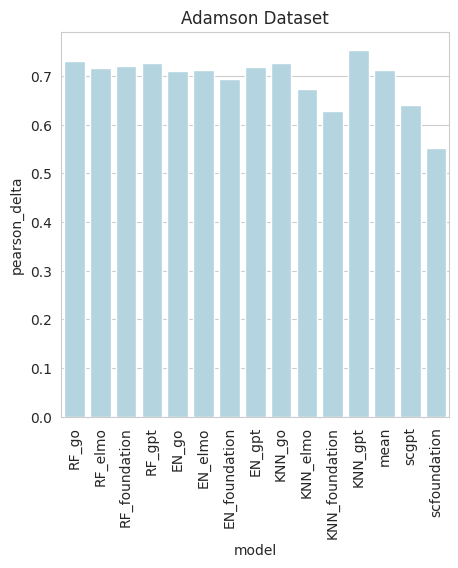

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=adamson_results, color='lightblue', ax=axs)
axs.set_title("Adamson Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Norman

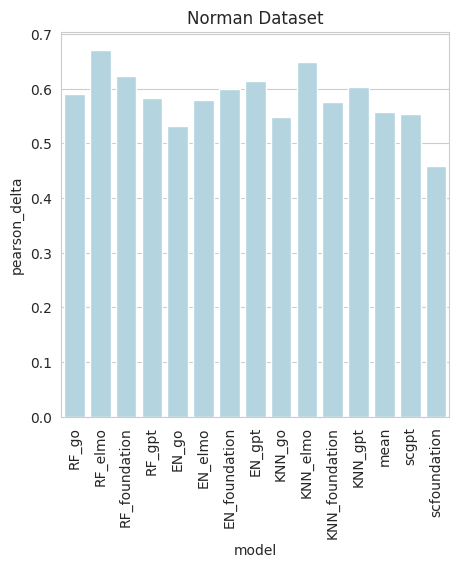

In [13]:
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=norman_results, color='lightblue', ax=axs)
axs.set_title("Norman Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle

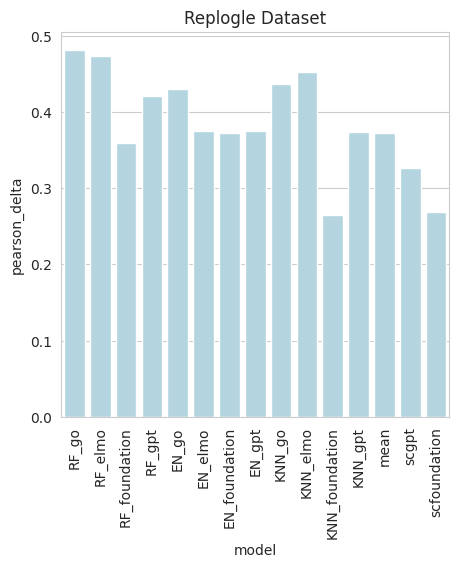

In [14]:
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_results, color='lightblue', ax=axs)
axs.set_title("Replogle Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle RP1

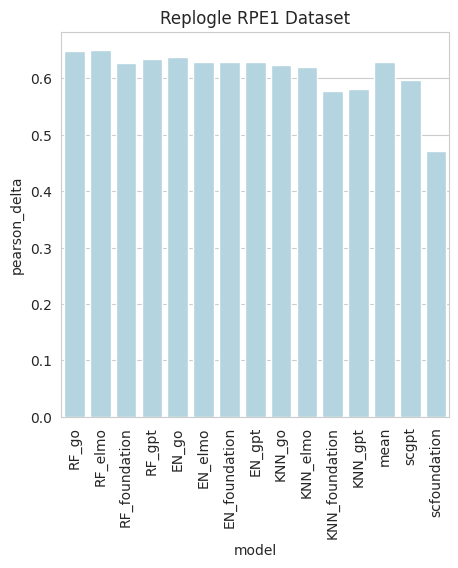

In [15]:
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_rp1_results, color='lightblue', ax=axs)
axs.set_title("Replogle RPE1 Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Supplementary

In [16]:
# table
adamson_results

,model,pearson,pearson_delta,pearson_de_delta,pearson_delta_de_no_knockout,pearson_de
0,RF_go,0.992234,0.730154,0.739575,0.793849,NaN
1,RF_elmo,0.992618,0.716101,0.730584,0.785977,NaN
2,RF_foundation,0.992792,0.719797,0.729638,0.785242,NaN
3,RF_gpt,0.992912,0.727303,0.734729,0.789791,NaN
4,EN_go,0.992352,0.709693,0.753593,0.808399,NaN
5,EN_elmo,0.992595,0.711098,0.730740,0.786347,NaN
6,EN_foundation,0.992185,0.694034,0.713661,0.769335,NaN
7,EN_gpt,0.992792,0.718377,0.737987,0.793267,NaN
8,KNN_go,0.992932,0.726704,0.769766,0.826789,NaN
9,KNN_elmo,0.990621,0.673249,0.715715,0.769994,NaN


In [35]:
df = pd.read_csv("/home/users/geroldcsendes/PertBench/PerturbBenchmark/data/DE_anal/adamson_DE.csv", index_col=0).T

In [36]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SCYL1+ctrl,ENSG00000112306,ENSG00000171858,ENSG00000197756,ENSG00000179218,ENSG00000145592,ENSG00000108107,ENSG00000166710,ENSG00000213741,ENSG00000167004,ENSG00000135404,ENSG00000143870,ENSG00000130203,ENSG00000177954,ENSG00000233927,ENSG00000102265,ENSG00000168906,ENSG00000186480,ENSG00000134419,ENSG00000197958,ENSG00000160932
MRPL39+ctrl,ENSG00000154719,ENSG00000112306,ENSG00000197756,ENSG00000171858,ENSG00000145592,ENSG00000233927,ENSG00000213741,ENSG00000108107,ENSG00000135404,ENSG00000130203,ENSG00000177954,ENSG00000124172,ENSG00000166710,ENSG00000134419,ENSG00000089248,ENSG00000172270,ENSG00000105193,ENSG00000149925,ENSG00000149516,ENSG00000093010
COPZ1+ctrl,ENSG00000111481,ENSG00000102265,ENSG00000171858,ENSG00000197756,ENSG00000166710,ENSG00000145592,ENSG00000112306,ENSG00000124172,ENSG00000213741,ENSG00000233927,ENSG00000149925,ENSG00000227706,ENSG00000116161,ENSG00000100906,ENSG00000142227,ENSG00000135404,ENSG00000142669,ENSG00000134419,ENSG00000197728,ENSG00000177954
SEC61A1+ctrl,ENSG00000168003,ENSG00000135404,ENSG00000104341,ENSG00000051523,ENSG00000130203,ENSG00000117410,ENSG00000187514,ENSG00000007255,ENSG00000093010,ENSG00000171858,ENSG00000149516,ENSG00000142227,ENSG00000206172,ENSG00000197756,ENSG00000145592,ENSG00000084207,ENSG00000099901,ENSG00000149925,ENSG00000069482,ENSG00000139644
HARS+ctrl,ENSG00000167996,ENSG00000187514,ENSG00000089248,ENSG00000166710,ENSG00000145592,ENSG00000130656,ENSG00000251562,ENSG00000206172,ENSG00000173812,ENSG00000135404,ENSG00000092621,ENSG00000132386,ENSG00000149925,ENSG00000089327,ENSG00000213741,ENSG00000233927,ENSG00000185198,ENSG00000069482,ENSG00000166295,ENSG00000171858


In [37]:
pred = pd.read_csv("/home/users/geroldcsendes/PertBench/PerturbBenchmark/notebooks/save/adamson/RF/elmo/predictions.csv", index_col=0)

In [49]:
mypred = np.load("/home/users/geroldcsendes/PertBench/PerturbBenchmark/notebooks/save/adamson/RF/elmo/test_res_best_model.npz", allow_pickle=True)

In [50]:
for k, v in mypred.items():
    print(k, v.shape)

pert_cat (22,)
pred (22, 5060)
truth (22, 5060)


In [38]:
pred.shape, df.shape

((22, 5060), (86, 20))

In [40]:
df = df.loc[pred.index].copy()

In [41]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
condition,,,,,,,,,,,,,,,,,,,,
CREB1+ctrl,ENSG00000169100,ENSG00000124614,ENSG00000177954,ENSG00000197756,ENSG00000002586,ENSG00000167996,ENSG00000108107,ENSG00000105193,ENSG00000172809,ENSG00000145592,ENSG00000144713,ENSG00000231500,ENSG00000142937,ENSG00000241343,ENSG00000197958,ENSG00000187514,ENSG00000112306,ENSG00000168003,ENSG00000168209,ENSG00000175197
BHLHE40+ctrl,ENSG00000169100,ENSG00000177954,ENSG00000124614,ENSG00000167996,ENSG00000002586,ENSG00000197756,ENSG00000064886,ENSG00000108107,ENSG00000105193,ENSG00000144713,ENSG00000142937,ENSG00000145592,ENSG00000197958,ENSG00000172809,ENSG00000168003,ENSG00000161970,ENSG00000133639,ENSG00000112306,ENSG00000175197,ENSG00000187514
IER3IP1+ctrl,ENSG00000143870,ENSG00000167004,ENSG00000134049,ENSG00000179218,ENSG00000171858,ENSG00000112306,ENSG00000145592,ENSG00000197756,ENSG00000130203,ENSG00000166794,ENSG00000135404,ENSG00000108107,ENSG00000166710,ENSG00000213741,ENSG00000149925,ENSG00000102265,ENSG00000233927,ENSG00000197958,ENSG00000168003,ENSG00000188846
DAD1+ctrl,ENSG00000129562,ENSG00000112306,ENSG00000108107,ENSG00000145592,ENSG00000171858,ENSG00000197756,ENSG00000197958,ENSG00000233927,ENSG00000213741,ENSG00000177954,ENSG00000142937,ENSG00000130203,ENSG00000144713,ENSG00000168906,ENSG00000105193,ENSG00000188846,ENSG00000134419,ENSG00000166710,ENSG00000142541,ENSG00000135404
AMIGO3+ctrl,ENSG00000108107,ENSG00000112306,ENSG00000171858,ENSG00000197756,ENSG00000145592,ENSG00000197958,ENSG00000142541,ENSG00000177954,ENSG00000188846,ENSG00000168906,ENSG00000142937,ENSG00000233927,ENSG00000144713,ENSG00000130203,ENSG00000213741,ENSG00000134419,ENSG00000105193,ENSG00000166710,ENSG00000149925,ENSG00000186468
DARS+ctrl,ENSG00000115866,ENSG00000110492,ENSG00000149925,ENSG00000124172,ENSG00000197756,ENSG00000233927,ENSG00000213741,ENSG00000149516,ENSG00000173812,ENSG00000167996,ENSG00000130656,ENSG00000185686,ENSG00000089248,ENSG00000171858,ENSG00000160932,ENSG00000145592,ENSG00000124614,ENSG00000187514,ENSG00000089327,ENSG00000112306
SYVN1+ctrl,ENSG00000108107,ENSG00000112306,ENSG00000145592,ENSG00000171858,ENSG00000197756,ENSG00000233927,ENSG00000177954,ENSG00000197958,ENSG00000213741,ENSG00000144713,ENSG00000142937,ENSG00000134419,ENSG00000188846,ENSG00000105193,ENSG00000168906,ENSG00000142541,ENSG00000185686,ENSG00000186468,ENSG00000167004,ENSG00000149925
GMPPB+ctrl,ENSG00000108107,ENSG00000112306,ENSG00000145592,ENSG00000171858,ENSG00000177954,ENSG00000197756,ENSG00000233927,ENSG00000213741,ENSG00000197958,ENSG00000144713,ENSG00000142541,ENSG00000142937,ENSG00000188846,ENSG00000105193,ENSG00000168906,ENSG00000134419,ENSG00000130203,ENSG00000166710,ENSG00000186468,ENSG00000026025
CAD+ctrl,ENSG00000112306,ENSG00000147403,ENSG00000142541,ENSG00000145592,ENSG00000090013,ENSG00000196565,ENSG00000197958,ENSG00000084207,ENSG00000233927,ENSG00000158578,ENSG00000177954,ENSG00000167996,ENSG00000117289,ENSG00000130656,ENSG00000149925,ENSG00000110492,ENSG00000105610,ENSG00000177410,ENSG00000197756,ENSG00000092068


In [42]:
pred

,ENSG00000228463,ENSG00000272438,ENSG00000230699,ENSG00000223764,ENSG00000187634,ENSG00000188290,ENSG00000187608,ENSG00000162571,ENSG00000186891,ENSG00000186827,...,ENSG00000160255,ENSG00000227039,ENSG00000223768,ENSG00000228355,ENSG00000182871,ENSG00000233922,ENSG00000142156,ENSG00000228137,ENSG00000160298,ENSG00000160299
condition,,,,,,,,,,,,,,,,,,,,,
CREB1+ctrl,0.000446,0.000028,0.005772,0.001278,0.004728,0.404603,0.633619,0.011232,0.002210,0.003815,...,0.047034,0.017699,0.025501,0.000602,0.593407,0.046110,0.000211,0.001134,0.204101,0.257227
BHLHE40+ctrl,0.000351,0.000064,0.005630,0.001148,0.003958,0.434892,0.633109,0.009854,0.002195,0.003992,...,0.037194,0.018153,0.022505,0.000750,0.651779,0.054543,0.000213,0.001080,0.209913,0.268670
IER3IP1+ctrl,0.000462,0.000042,0.005499,0.001373,0.003914,0.405751,0.633346,0.009630,0.001489,0.004073,...,0.036619,0.016977,0.023363,0.000936,0.620824,0.052315,0.000226,0.000672,0.200659,0.253316
DAD1+ctrl,0.000591,0.000028,0.005777,0.001413,0.003661,0.462857,0.645407,0.010220,0.002108,0.003682,...,0.035468,0.017704,0.022710,0.000993,0.642030,0.059818,0.000423,0.000825,0.217704,0.275634
AMIGO3+ctrl,0.000577,0.000064,0.005816,0.001087,0.004227,0.458681,0.643147,0.009936,0.001680,0.002860,...,0.037588,0.016422,0.024003,0.000842,0.645953,0.054917,0.000286,0.001195,0.213198,0.271358
DARS+ctrl,0.000857,0.000078,0.006975,0.001157,0.007213,0.387332,0.673815,0.014569,0.002862,0.003995,...,0.058717,0.021686,0.026824,0.000497,0.521726,0.040910,0.000121,0.001583,0.213966,0.260795
SYVN1+ctrl,0.000537,0.000028,0.006543,0.001316,0.004300,0.472140,0.638940,0.010938,0.001888,0.003288,...,0.042080,0.017991,0.022484,0.000698,0.649287,0.055624,0.000274,0.000929,0.207747,0.265908
GMPPB+ctrl,0.000494,0.000050,0.005920,0.001643,0.004585,0.470672,0.641967,0.009948,0.002503,0.004216,...,0.036542,0.018231,0.022318,0.000745,0.638462,0.061312,0.000372,0.000882,0.211867,0.275103
CAD+ctrl,0.000403,0.000093,0.006674,0.001223,0.005472,0.430157,0.659671,0.012820,0.002528,0.003362,...,0.052344,0.020196,0.024751,0.000595,0.614361,0.050476,0.000163,0.001204,0.210175,0.268390


In [24]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SCYL1+ctrl,ENSG00000112306,ENSG00000171858,ENSG00000197756,ENSG00000179218,ENSG00000145592,ENSG00000108107,ENSG00000166710,ENSG00000213741,ENSG00000167004,ENSG00000135404,ENSG00000143870,ENSG00000130203,ENSG00000177954,ENSG00000233927,ENSG00000102265,ENSG00000168906,ENSG00000186480,ENSG00000134419,ENSG00000197958,ENSG00000160932
MRPL39+ctrl,ENSG00000154719,ENSG00000112306,ENSG00000197756,ENSG00000171858,ENSG00000145592,ENSG00000233927,ENSG00000213741,ENSG00000108107,ENSG00000135404,ENSG00000130203,ENSG00000177954,ENSG00000124172,ENSG00000166710,ENSG00000134419,ENSG00000089248,ENSG00000172270,ENSG00000105193,ENSG00000149925,ENSG00000149516,ENSG00000093010
COPZ1+ctrl,ENSG00000111481,ENSG00000102265,ENSG00000171858,ENSG00000197756,ENSG00000166710,ENSG00000145592,ENSG00000112306,ENSG00000124172,ENSG00000213741,ENSG00000233927,ENSG00000149925,ENSG00000227706,ENSG00000116161,ENSG00000100906,ENSG00000142227,ENSG00000135404,ENSG00000142669,ENSG00000134419,ENSG00000197728,ENSG00000177954
SEC61A1+ctrl,ENSG00000168003,ENSG00000135404,ENSG00000104341,ENSG00000051523,ENSG00000130203,ENSG00000117410,ENSG00000187514,ENSG00000007255,ENSG00000093010,ENSG00000171858,ENSG00000149516,ENSG00000142227,ENSG00000206172,ENSG00000197756,ENSG00000145592,ENSG00000084207,ENSG00000099901,ENSG00000149925,ENSG00000069482,ENSG00000139644
HARS+ctrl,ENSG00000167996,ENSG00000187514,ENSG00000089248,ENSG00000166710,ENSG00000145592,ENSG00000130656,ENSG00000251562,ENSG00000206172,ENSG00000173812,ENSG00000135404,ENSG00000092621,ENSG00000132386,ENSG00000149925,ENSG00000089327,ENSG00000213741,ENSG00000233927,ENSG00000185198,ENSG00000069482,ENSG00000166295,ENSG00000171858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF326+ctrl,ENSG00000169100,ENSG00000177954,ENSG00000124614,ENSG00000197756,ENSG00000002586,ENSG00000167996,ENSG00000144713,ENSG00000105193,ENSG00000108107,ENSG00000172809,ENSG00000145592,ENSG00000142937,ENSG00000197958,ENSG00000112306,ENSG00000161970,ENSG00000162664,ENSG00000231500,ENSG00000087086,ENSG00000168003,ENSG00000241343
ATP5B+ctrl,ENSG00000110955,ENSG00000233927,ENSG00000149516,ENSG00000213741,ENSG00000171858,ENSG00000197756,ENSG00000112306,ENSG00000145592,ENSG00000108107,ENSG00000166710,ENSG00000089248,ENSG00000093010,ENSG00000124172,ENSG00000110492,ENSG00000172270,ENSG00000177954,ENSG00000092621,ENSG00000135404,ENSG00000134419,ENSG00000132386
DNAJC19+ctrl,ENSG00000205981,ENSG00000233927,ENSG00000145592,ENSG00000167996,ENSG00000110492,ENSG00000197756,ENSG00000213741,ENSG00000171858,ENSG00000112306,ENSG00000135404,ENSG00000089248,ENSG00000134419,ENSG00000166710,ENSG00000108107,ENSG00000172270,ENSG00000142669,ENSG00000130429,ENSG00000185198,ENSG00000124172,ENSG00000105193
IER3IP1+ctrl,ENSG00000143870,ENSG00000167004,ENSG00000134049,ENSG00000179218,ENSG00000171858,ENSG00000112306,ENSG00000145592,ENSG00000197756,ENSG00000130203,ENSG00000166794,ENSG00000135404,ENSG00000108107,ENSG00000166710,ENSG00000213741,ENSG00000149925,ENSG00000102265,ENSG00000233927,ENSG00000197958,ENSG00000168003,ENSG00000188846


In [23]:

pred

,condition,ENSG00000228463,ENSG00000272438,ENSG00000230699,ENSG00000223764,ENSG00000187634,ENSG00000188290,ENSG00000187608,ENSG00000162571,ENSG00000186891,...,ENSG00000160255,ENSG00000227039,ENSG00000223768,ENSG00000228355,ENSG00000182871,ENSG00000233922,ENSG00000142156,ENSG00000228137,ENSG00000160298,ENSG00000160299
0,CREB1+ctrl,0.000446,0.000028,0.005772,0.001278,0.004728,0.404603,0.633619,0.011232,0.002210,...,0.047034,0.017699,0.025501,0.000602,0.593407,0.046110,0.000211,0.001134,0.204101,0.257227
1,BHLHE40+ctrl,0.000351,0.000064,0.005630,0.001148,0.003958,0.434892,0.633109,0.009854,0.002195,...,0.037194,0.018153,0.022505,0.000750,0.651779,0.054543,0.000213,0.001080,0.209913,0.268670
2,IER3IP1+ctrl,0.000462,0.000042,0.005499,0.001373,0.003914,0.405751,0.633346,0.009630,0.001489,...,0.036619,0.016977,0.023363,0.000936,0.620824,0.052315,0.000226,0.000672,0.200659,0.253316
3,DAD1+ctrl,0.000591,0.000028,0.005777,0.001413,0.003661,0.462857,0.645407,0.010220,0.002108,...,0.035468,0.017704,0.022710,0.000993,0.642030,0.059818,0.000423,0.000825,0.217704,0.275634
4,AMIGO3+ctrl,0.000577,0.000064,0.005816,0.001087,0.004227,0.458681,0.643147,0.009936,0.001680,...,0.037588,0.016422,0.024003,0.000842,0.645953,0.054917,0.000286,0.001195,0.213198,0.271358
5,DARS+ctrl,0.000857,0.000078,0.006975,0.001157,0.007213,0.387332,0.673815,0.014569,0.002862,...,0.058717,0.021686,0.026824,0.000497,0.521726,0.040910,0.000121,0.001583,0.213966,0.260795
6,SYVN1+ctrl,0.000537,0.000028,0.006543,0.001316,0.004300,0.472140,0.638940,0.010938,0.001888,...,0.042080,0.017991,0.022484,0.000698,0.649287,0.055624,0.000274,0.000929,0.207747,0.265908
7,GMPPB+ctrl,0.000494,0.000050,0.005920,0.001643,0.004585,0.470672,0.641967,0.009948,0.002503,...,0.036542,0.018231,0.022318,0.000745,0.638462,0.061312,0.000372,0.000882,0.211867,0.275103
8,CAD+ctrl,0.000403,0.000093,0.006674,0.001223,0.005472,0.430157,0.659671,0.012820,0.002528,...,0.052344,0.020196,0.024751,0.000595,0.614361,0.050476,0.000163,0.001204,0.210175,0.268390
9,GNPNAT1+ctrl,0.000707,0.000043,0.005557,0.001216,0.004976,0.459978,0.651250,0.010371,0.002442,...,0.040728,0.018440,0.021443,0.000776,0.646356,0.057902,0.000283,0.001110,0.216688,0.277261
